In [1]:
# Installing and importing necessary libraries
!pip install tf-keras
!pip install transformers datasets peft evaluate torchinfo
!pip install --upgrade git+https://github.com/huggingface/peft.git
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
from transformers import RobertaForSequenceClassification
import torch
import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt

In [3]:
test_df = pd.read_pickle("test_unlabelled.pkl")
test_df[0]  # View first row

{'text': 'Remains of New Species of Hobbit-Sized Human Found Scientists in Australia have found a new species of hobbit-sized humans who lived about 18,000 years ago on an Indonesian island in a discovery that adds another piece to the complex puzzle of human evolution.'}

In [4]:
# Load dataset
dataset = load_dataset("ag_news")

# Load tokenizer and tokenize data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)

# Load model configuration and model with 4 output labels
config = RobertaConfig.from_pretrained("roberta-base", num_labels=4)
model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config)

# Apply LoRA
lora_config = LoraConfig(
    r=4,  # LoRA rank
    lora_alpha=16,  # strength
    target_modules=["query", "value"],  # typically works well
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(model, lora_config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    fp16=True
)

# Metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# Trainer
from transformers import Trainer

class PatchedTrainer(Trainer):
    def training_step(self, model, inputs, num_items_in_batch=None):
        inputs.pop("num_items_in_batch", None)
        return super().training_step(model, inputs, num_items_in_batch)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        inputs.pop("num_items_in_batch", None)
        return super().compute_loss(model, inputs, return_outputs)

trainer = PatchedTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-5-1b0abe00db7e>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `PatchedTrainer.__init__`. Use `processing_class` instead.
  trainer = PatchedTrainer(


In [6]:
# Model summary for parameter count check
summary(model, input_size=(1, 128), dtypes=[torch.long])

# Training (commented out to prevent execution here)
trainer.train()

# Save model and tokenizer
model.save_pretrained("./lora-roberta-agnews")
tokenizer.save_pretrained("./lora-roberta-agnews")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jp7431 (jp7431-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.198100,0.188941,0.936316
2,0.179900,0.174222,0.941711
3,0.158700,0.170020,0.945132


('./lora-roberta-agnews/tokenizer_config.json',
 './lora-roberta-agnews/special_tokens_map.json',
 './lora-roberta-agnews/vocab.json',
 './lora-roberta-agnews/merges.txt',
 './lora-roberta-agnews/added_tokens.json')

In [7]:
# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("./lora-roberta-agnews")
model.eval()
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize test data
def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

test_encoded = test_df.map(tokenize_fn, batched=True)

# Convert to PyTorch tensors
test_encoded.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Run inference
preds = []
for batch in tqdm(test_encoded, desc="Predicting"):
    input_ids = batch["input_ids"].unsqueeze(0).to(model.device)
    attention_mask = batch["attention_mask"].unsqueeze(0).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        preds.append(predicted_class)

# Create submission file
submission_df = pd.DataFrame({
    "ID": list(range(len(preds))),
    "Label": preds
})
submission_df.to_csv("submission.csv", index=False)
print("submission.csv generated.")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Predicting: 100%|██████████| 8000/8000 [02:31<00:00, 52.72it/s]


submission.csv generated.


In [8]:
# Plotting the training plots
steps, train_loss, eval_loss, eval_acc = [], [], [], []
history = trainer.state.log_history
for row in history:
    if "loss" in row and "eval_loss" not in row:
        train_loss.append(row["loss"])
        steps.append(row["step"])
    if "eval_loss" in row:
        eval_loss.append(row["eval_loss"])
    if "eval_accuracy" in row:
        eval_acc.append(row["eval_accuracy"])

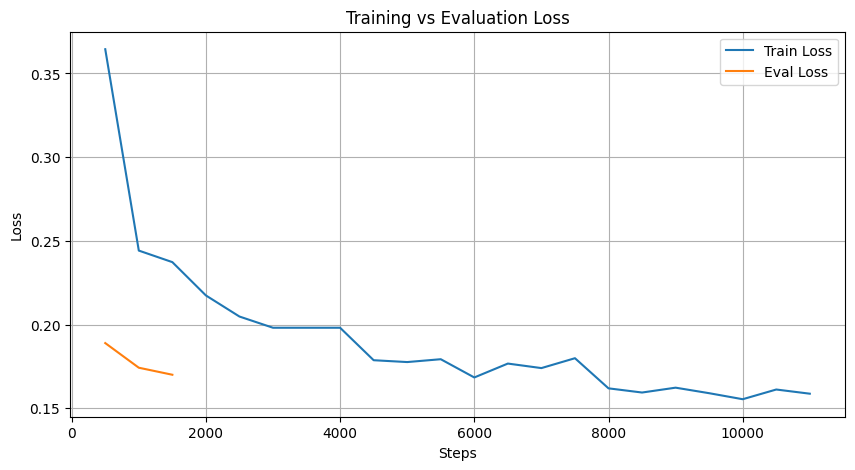

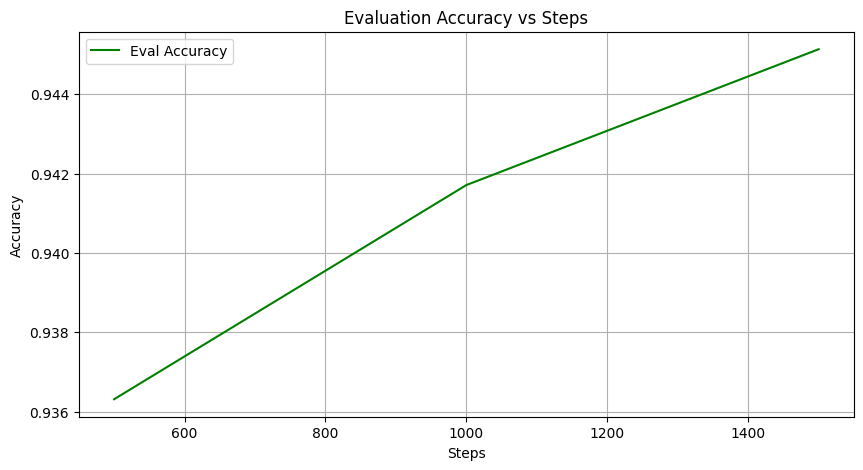

In [10]:
# Plot Evaluation
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(eval_acc)], eval_acc, label="Eval Accuracy", color='green')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy vs Steps")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png")
plt.show()
